In [1]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pptoolbox.visualization import initialize_theme
from pptoolbox.utils import preprocess, WAVELENGTHS_3NM_V1

from pathlib import Path

cmaps = initialize_theme()

Registered profileprint_light_cmap
Registered profileprint_diverging_cmap


### Load Data

In [2]:
data_dir = Path("../models/platform/6548")

In [3]:
input_df = pd.read_csv(data_dir/'input.csv')
label_df = pd.read_csv(data_dir/'label.csv')
input_df.shape, label_df.shape

((160, 4), (40, 6))

In [4]:
spectra, _ = preprocess(input_df, wavelengths=WAVELENGTHS_3NM_V1)
spectra.shape

(160, 191)

In [6]:
label_df

,lot_id,TTA,Brix,Turbidity,T625,T440
0,89670,2.44,70.55,0,99.9,87.5
1,89671,2.43,70.72,0,96.4,84.5
2,89672,2.44,70.46,0,99.9,86.7
3,89673,2.38,70.78,0,99.9,86.9
4,89675,2.43,70.48,0,100.0,87.9
5,89676,2.46,70.70,1,99.9,87.5
6,89677,2.46,70.76,0,99.8,87.6
7,89678,2.44,70.60,0,99.7,87.0
8,89679,2.37,70.60,1,99.5,86.8
9,89680,2.44,70.40,3,100.0,86.5


In [22]:
-(-len(label_df.drop(columns='lot_id').columns)//2)

3

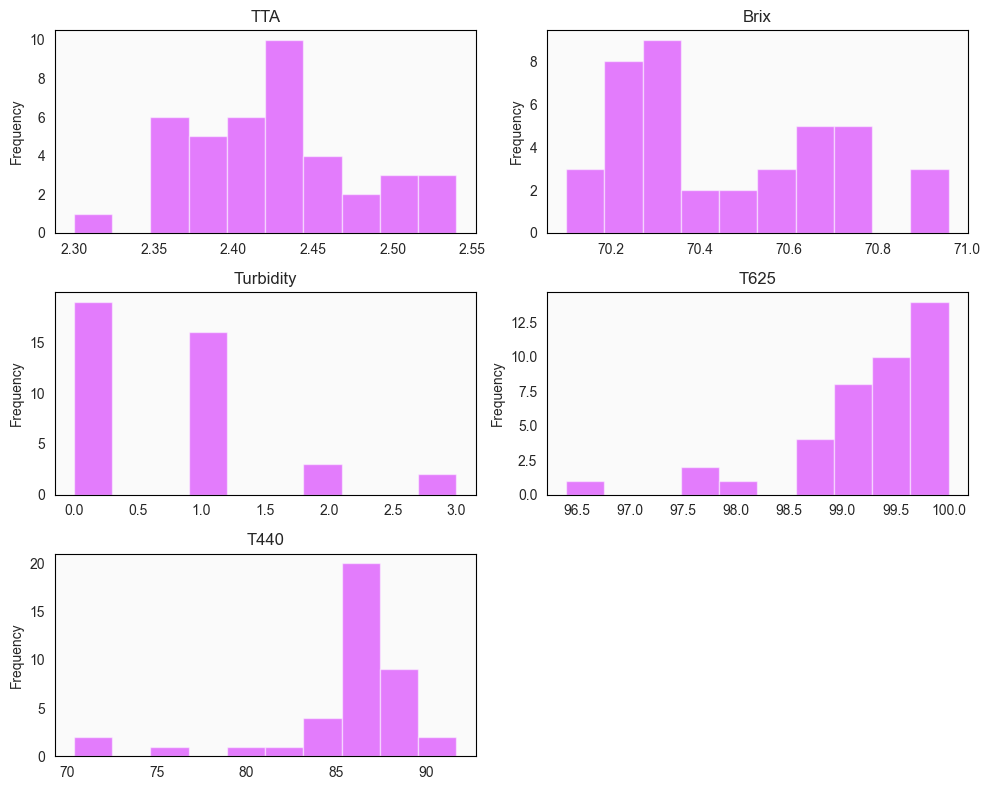

In [24]:
f, ax = plt.subplots(-(-len(label_df.drop(columns='lot_id').columns)//2), 2, figsize=(10, 8))

for i, column in enumerate(label_df.drop(columns='lot_id').columns):
    label_df[column].plot(kind='hist', ax=f.axes[i], title=column, alpha=0.5, label=column)

#remove empty plots
f.delaxes(ax[-1, -1])

In [26]:
X, y = preprocess(input_df, label_df, wavelengths=WAVELENGTHS_3NM_V1)
X.shape, y.shape

((160, 191), (160, 5))

# plot functions

In [228]:
def coldrop(model_weights, base_wavelengths):
    difference = len(base_wavelengths) - len(model_weights.ravel())
    num_to_slice = difference/2
    return base_wavelengths[int(num_to_slice):int(-num_to_slice)] if num_to_slice != 0 else base_wavelengths

In [229]:
base_wavelengths = np.arange(480, 1051, 3)

In [253]:
def plot_weights(adjusted_weights, curr_wavelengths, parameter):

    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.lineplot(y=adjusted_weights, x=curr_wavelengths, ax=ax[0])

    relative_weights = abs(adjusted_weights)
    relative_weights = relative_weights/relative_weights.sum()
    sns.lineplot(y=relative_weights, x=curr_wavelengths, ax=ax[1])
    ax[1].axvline(x=650, color='black', ls='--')
    ax[1].axvline(x=750, color='black', ls='--')
    ax[1].axvline(x=850, color='black', ls='--')
    ax[1].axvline(x=950, color='black', ls='--')

    def get_affected_weight_sum(lower_limit, upper_limit,relative_weights):
        affected_region_mask = ((curr_wavelengths > lower_limit) & (curr_wavelengths <= upper_limit))
        weight_sum = relative_weights[affected_region_mask].sum()
        return weight_sum

    def label_affected_weight_sum(lower_limit, upper_limit, relative_weights, ax):
        weight_sum = get_affected_weight_sum(lower_limit, upper_limit, relative_weights) * 100
        ax.text(x=lower_limit+20, y = max(relative_weights), s=f'{weight_sum:.2f}%', fontsize=10)

    label_affected_weight_sum(650, 750, relative_weights, ax[1])
    label_affected_weight_sum(750, 850, relative_weights, ax[1])
    label_affected_weight_sum(850, 950, relative_weights, ax[1])

    ax[0].set(title='Model weights')
    ax[1].set(title='Relative Importance based on absolute model weights')
    plt.suptitle(f'{parameter} Model')
    plt.tight_layout()
    plt.show()
    plt.close()

    print(f"650-750: {get_affected_weight_sum(650, 750, relative_weights)}")
    print(f"750-850: {get_affected_weight_sum(750, 850, relative_weights)}")
    print(f"850-950: {get_affected_weight_sum(850, 950, relative_weights)}")

### Brix Model

In [242]:
with open(data_dir/'prediction/tasteprofile_model_Brix.pkl', 'rb') as f:
    model = pickle.load(f)

model

Pipeline(steps=[('SNV', SNV()), ('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(n_components=13, scale=False))])

In [247]:
# model_weights = model[-1].coef_
# pca_loadings = model[-2].components_
# print(model_weights.shape, pca_loadings.shape)
# print(model_weights.shape)

In [248]:
# curr_wavelengths = coldrop(model_weights,base_wavelengths)
# curr_wavelengths.shape

In [250]:
# predictions = model.predict(spectra)

In [251]:
# model[-1].intercept_[0]

In [236]:
# all((model[:-1].transform(spectra) @ model_weights + model[-1].intercept_[0]) == predictions)

In [237]:
# pc_scores = model[:-2].transform(spectra) @ pca_loadings.T 
# all(np.isclose((pc_scores @ model_weights + model[-1].intercept_), predictions))

In [238]:
# (pca_loadings.T @ model_weights).shape

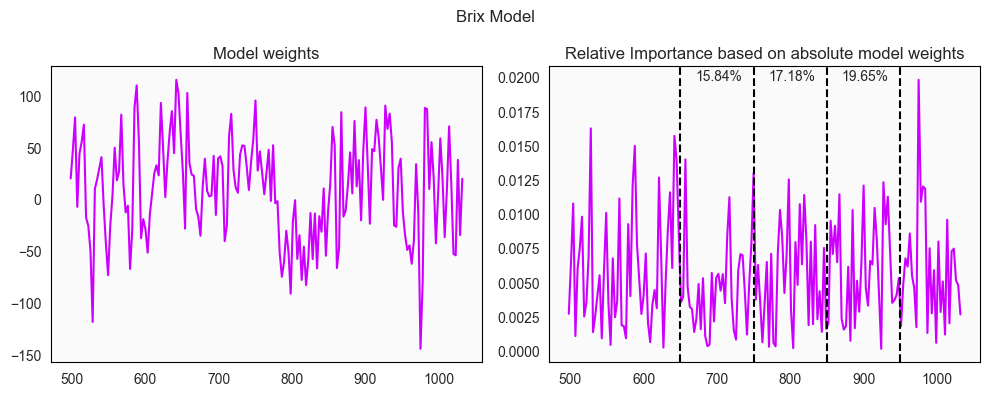

650-750: 0.15836010441841344
750-850: 0.1718341966200645
850-950: 0.1964895460389017


In [254]:
model_weights = model[-1].coef_.ravel()
# pca_loadings = model[-2].components_
# adjusted_weights = pca_loadings.T @ model_weights
adjusted_weights = model_weights
curr_wavelengths = coldrop(model_weights,base_wavelengths)

plot_weights(adjusted_weights, curr_wavelengths, 'Brix')

### T440

In [255]:
with open(data_dir/'prediction/tasteprofile_model_T440.pkl', 'rb') as f:
    model = pickle.load(f)

In [256]:
model

Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=11)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(scale=False))])

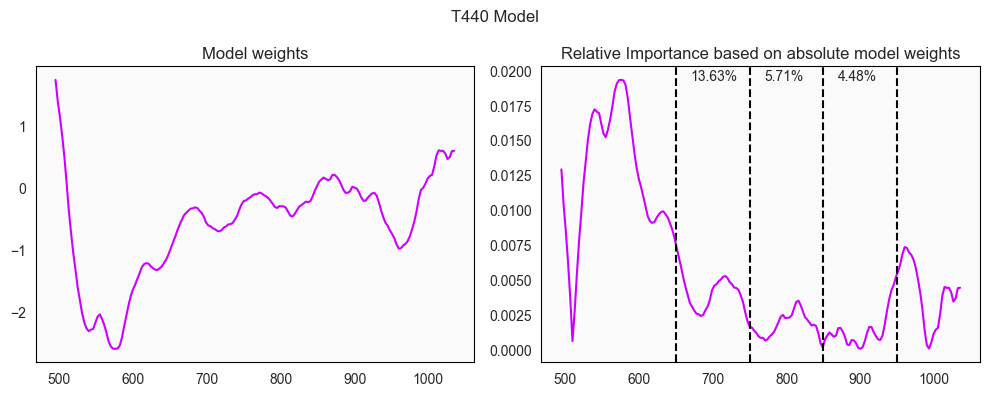

650-750: 0.13626229278386393
750-850: 0.05709263139162403
850-950: 0.04483190020233217


In [258]:
model_weights = model[-1].coef_.ravel()
# pca_loadings = model[-2].components_
# print(model_weights.shape, pca_loadings.shape)
curr_wavelengths = coldrop(model_weights,base_wavelengths)

plot_weights(model_weights, curr_wavelengths, 'T440')

### TTA

In [259]:
with open(data_dir/'prediction/tasteprofile_model_TTA.pkl', 'rb') as f:
    model = pickle.load(f)

In [260]:
model

Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('Paggro',
                 PassiveAggressiveRegressor(C=0.022676502438312377,
                                            early_stopping=True,
                                            n_iter_no_change=48,
                                            random_state=42, shuffle=False))])

In [261]:
model_weights = model[-1].coef_
# pca_loadings = model[-2].components_
print(model_weights.shape)
# print(model_weights.shape, pca_loadings.shape)

(191,)


In [262]:
predictions = model.predict(spectra)

In [264]:
# all((model[:-1].transform(spectra) @ model_weights.ravel() + model[-1].intercept_) == predictions)

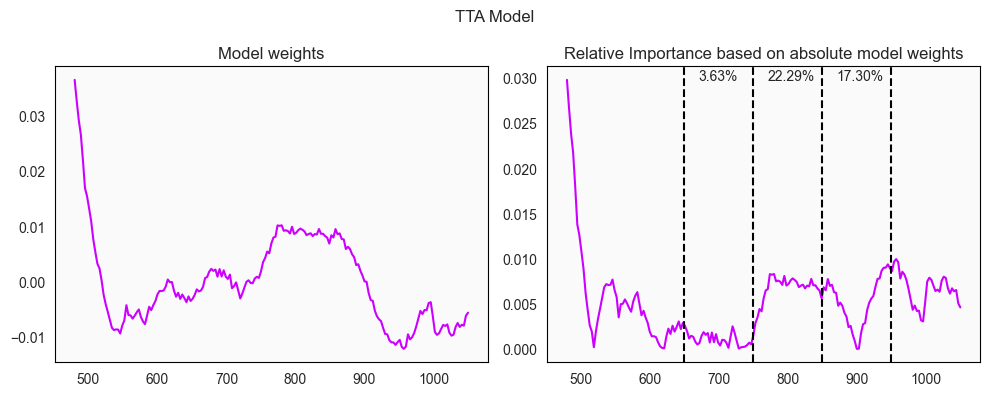

650-750: 0.036307039498919357
750-850: 0.22293657976463538
850-950: 0.1729967594500724


In [266]:
model_weights = model[-1].coef_.ravel()
# pca_loadings = model[-2].components_
# adjusted_weights = pca_loadings.T @ model_weights
adjusted_weights = model_weights
curr_wavelengths = coldrop(model_weights,base_wavelengths)

plot_weights(adjusted_weights, curr_wavelengths, 'TTA')

### Turbidity

In [267]:
with open(data_dir/'prediction/tasteprofile_model_Turbidity.pkl', 'rb') as f:
    model = pickle.load(f)

In [268]:
model

Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=31, random_state=42)),
                ('Lars', Lars(random_state=42))])

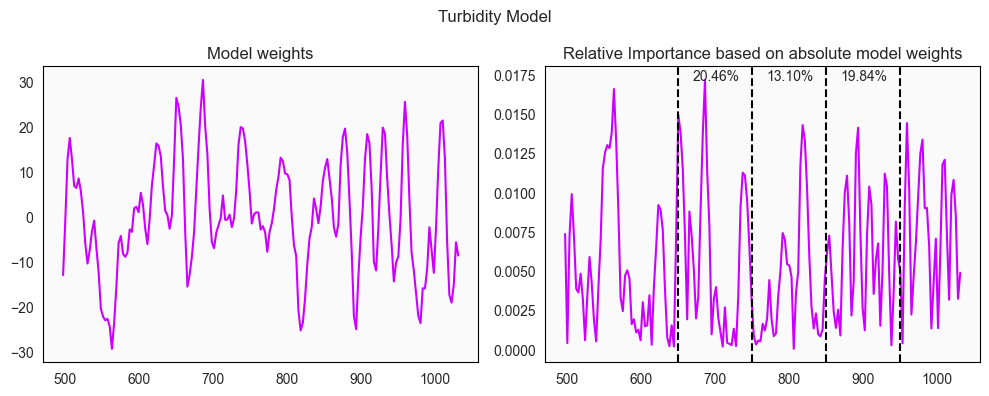

650-750: 0.2046286501577792
750-850: 0.13095672356265664
850-950: 0.19842542092526913


In [269]:
model_weights = model[-1].coef_.ravel()
pca_loadings = model[-2].components_
# print(model_weights.shape, pca_loadings.shape)
adjusted_weights =pca_loadings.T @ model_weights
# adjusted_weights = model_weights
# print(base_wavelengths.shape)
curr_wavelengths = coldrop(adjusted_weights,base_wavelengths)

plot_weights(adjusted_weights, curr_wavelengths, 'Turbidity')

# T625

In [270]:
with open(data_dir/'prediction/tasteprofile_model_T625.pkl', 'rb') as f:
    model = pickle.load(f)

In [271]:
model

Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=8, random_state=42)),
                ('Paggro',
                 PassiveAggressiveRegressor(C=0.015810973510234,
                                            early_stopping=True,
                                            n_iter_no_change=7, random_state=42,
                                            shuffle=False))])

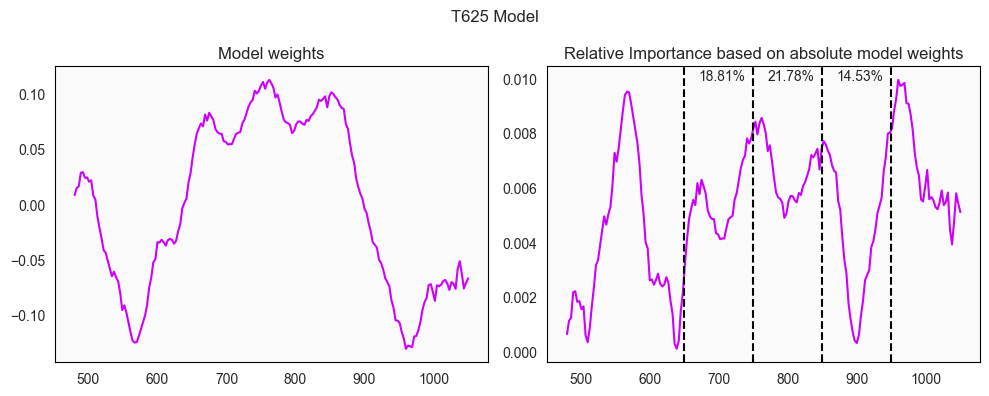

650-750: 0.18811813773204777
750-850: 0.21779415230826452
850-950: 0.14529983745141956


In [272]:
model_weights = model[-1].coef_.ravel()
pca_loadings = model[-2].components_
adjusted_weights =pca_loadings.T @ model_weights
# adjusted_weights = model_weights
curr_wavelengths = coldrop(adjusted_weights,base_wavelengths)

plot_weights(adjusted_weights, curr_wavelengths, 'T625')

# Plot the spectra

In [273]:
from pptoolbox.preprocessing import SNV

<Axes: title={'center': 'SNV Apple Juice Spectra'}>

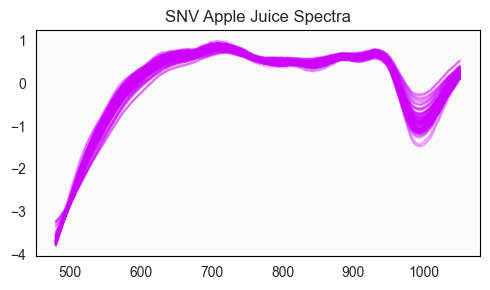

In [274]:
snv_spectra = SNV().fit_transform(spectra)
pd.DataFrame(snv_spectra, columns=spectra.columns).T.plot(legend=False, color=cmaps[0].colors[0], alpha=0.2,
                                                          figsize=(5,3), title='SNV Apple Juice Spectra')

In [275]:
label_df.set_index('lot_id').corr()

,TTA,Brix,Turbidity,T625,T440
TTA,1.000000,-0.202827,0.010500,0.074269,-0.071397
Brix,-0.202827,1.000000,0.146004,-0.297299,-0.241937
Turbidity,0.010500,0.146004,1.000000,-0.147405,-0.272331
T625,0.074269,-0.297299,-0.147405,1.000000,0.545592
T440,-0.071397,-0.241937,-0.272331,0.545592,1.000000
